In [ ]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots, colors

## colors

In [ ]:
colors_lst, red, cmap = colors.color_scheme()
cmap

# Parameters

In [ ]:
## Parameters

## task type
task_type='Regression'


# ## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.015, 0.1, 0.01, 0.03, 0.05, 0.12, 0.23, 0.25, 0.12, 0.1, 0.02, 0.3, 0.35, 0.25,
#                               0.03, 0.02, 0.25, 0.31, 0.02, 0.08, 0.35, 0.1, 0.03, 0.2, 0.1, 0.18, 0.12, 0.35, 0.05, 0.15,
#                               0.25, 0.25, 0.02, 0.01, 0.08, 0.07, 0.35, 0.15, 0.01, 0.25, 0.13, 0.05, 0.03, 0.3, 0.32, 0.05,
#                               0.15, 0.12, 0.25, 0.1, 0.25, 0.3, 0.25, 0.25, 0.04, 0.27, 0.1, 0.11, 0.02, 0.2, 0.4, 0.15,
#                               ])

## specify # of nodes
Nin: int = 0
extraNin: int = 0
Ninter: int = 0
Nout: int = 0
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.])

alpha: float = 0.1  # for network combine attempt
stay_sample: int = 2

# length of training dataset
iterations = int(4e4)  # number of sampled of p

stay_sample = 2

random_state = 42

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [ ]:
def network_build_given_Nin_Nout(Nin: int, Nout: int, M_values: NDArray[np.float_]) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(iterations,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    # normalize Nin*Nout values of M to norm of 0.5
    M_values_norm = normalize([M_values[:Nin*Nout]], norm="l1")[0]/2
    print('M_norm', M_values_norm)
    Variabs.create_dataset_and_targets(random_state, M_values_norm)
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def random_gen_M(random_state: int, size: NDArray[np.int_]) -> NDArray[np.float_]:
    """
    random_gen_M generates a random M_values array for regression task
    use for multiple_Nin_Nout for example, and before train_loop()
    
    inputs:
    random_state - int, random seed
    size         - size of M_values, train_loop then decides how many to take
    """
    # generate random state
    random_gen = np.random.RandomState(random_state)

    # Generate random values with the defined random state
    M_values = random_gen.rand(size)
    
    return M_values


def train_loop(Variabs, Strctr, State, BigClass):
    loss_mean = [1, 1]
    for l in range(Variabs.iterations):
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            State.calc_loss(BigClass)
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
        if not (l+1)%window_for_mean:
            # print('l', l)
            loss_mean.append(np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1)))
            # print(loss_mean)
            
        if loss_mean[-1]<10e-8 or (loss_mean[-1]-loss_mean[-2])>0 or loss_mean[-1]>2:
            break
            
    return State

# Loop

In [5]:
# window_for_mean = 1000
# n = 10
# random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
# norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])

# for k, random_state_M in enumerate(random_state_M_vec):
#     M_values = random_gen_M(random_state_M, n*n)
#     for i in range(n):
#         for j in range(n):
#             Nin: int = i + 1
#             Nout: int = j + 1
#             print('Nin', Nin)
#             print('Nout', Nout)

#             Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
#             State = train_loop(Variabs, Strctr, State, BigClass)

#             norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
#             # norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
#             print('norm_mean_loss_ij', norm_mean_loss_ij)

#             norm_mean_loss[i, j, k] = norm_mean_loss_ij
#             # plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

In [6]:
# save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

# np.save(save_folder_prelim + 'loss_mat.npy', norm_mean_loss)

In [7]:
# # Reload the module to reflect any changes made
# importlib.reload(figure_plots)

# figure_plots.loss_afo_in_out(norm_mean_loss, cmap)

In [11]:
np.mean(Variabs.targets)

5.2561403383618304e-05

Nin 1
Nout 1
M_norm [0.00398294]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3114209860906238
no NET assigned in input


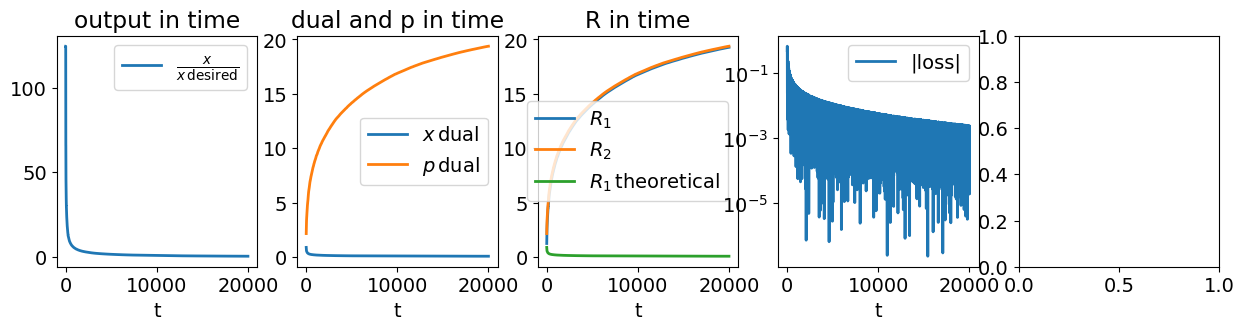

Nin 1
Nout 2
M_norm [0.00398294 0.01011009]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.20383719658114283
no NET assigned in input


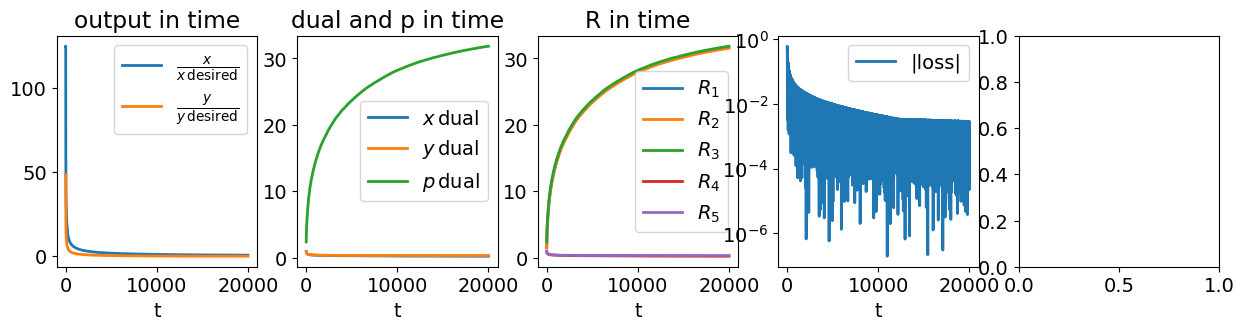

Nin 1
Nout 3
M_norm [0.00398294 0.01011009 0.00778418]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.17477673946588793
no NET assigned in input


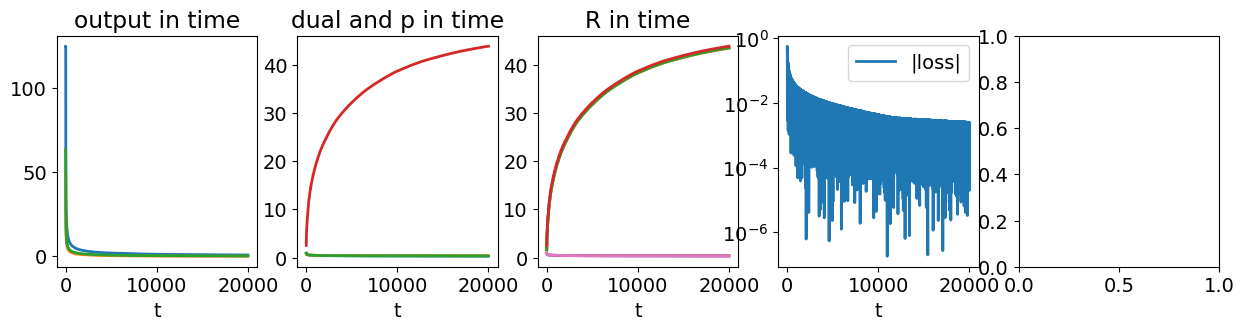

Nin 1
Nout 4
M_norm [0.00398294 0.01011009 0.00778418 0.00636626]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.18422066011478805
no NET assigned in input


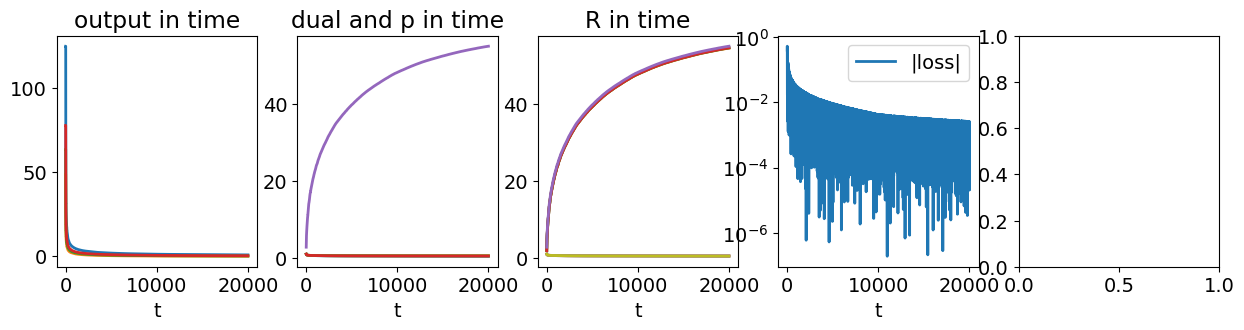

Nin 1
Nout 5
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.30647483308434825
no NET assigned in input


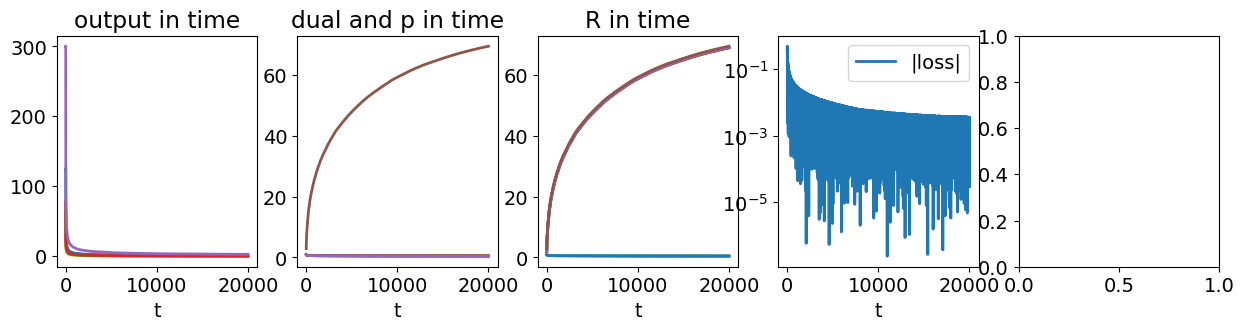

Nin 1
Nout 6
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913 0.00165888]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.4153187907100944
no NET assigned in input


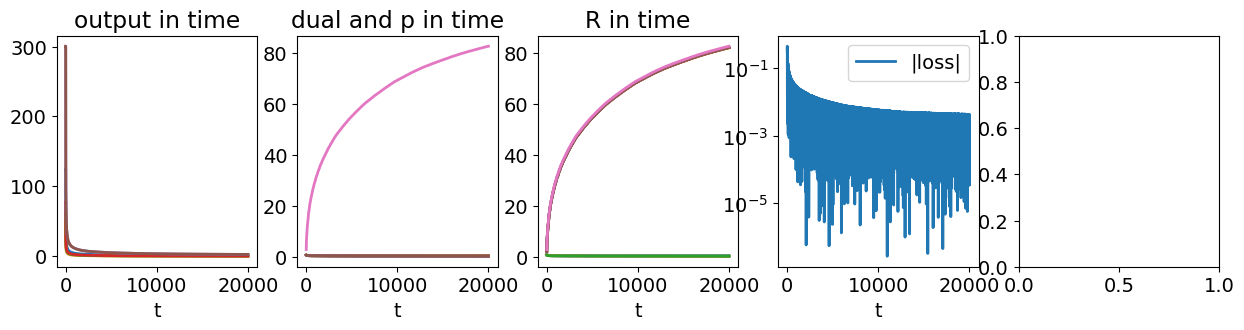

Nin 1
Nout 7
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913 0.00165888
 0.00061767]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.5454557935114214
no NET assigned in input


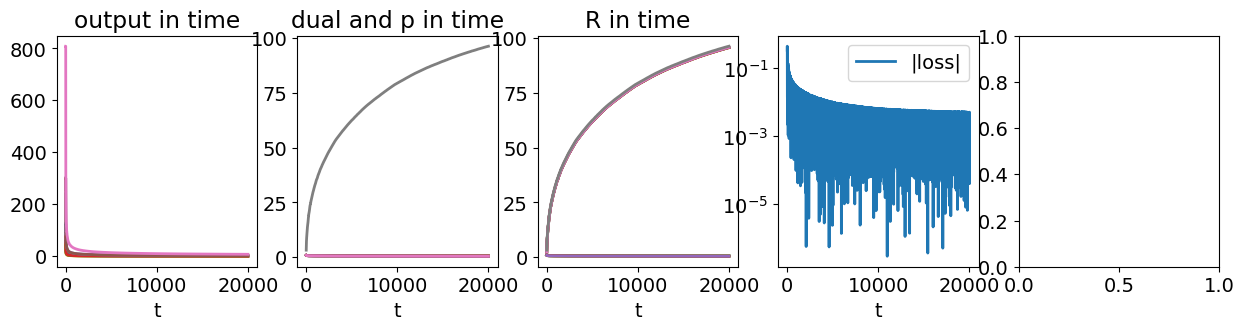

Nin 1
Nout 8
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913 0.00165888
 0.00061767 0.0092111 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.48202855141553286
no NET assigned in input


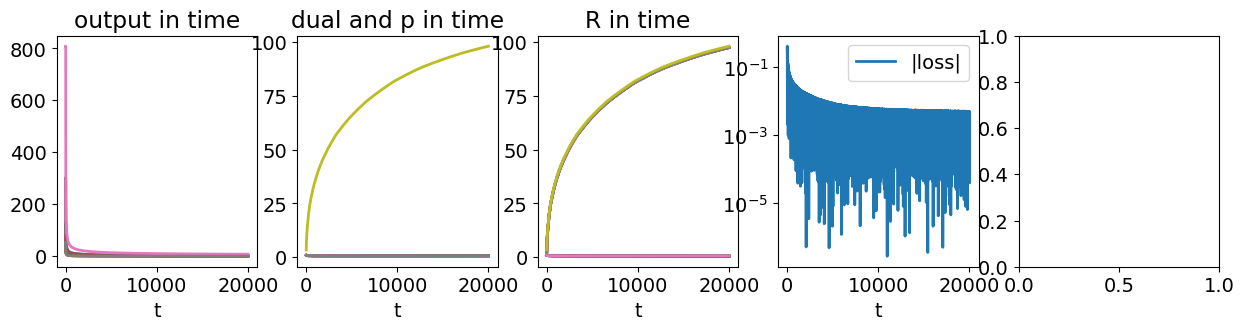

Nin 1
Nout 9
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913 0.00165888
 0.00061767 0.0092111  0.00639238]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.4232973613347236
no NET assigned in input


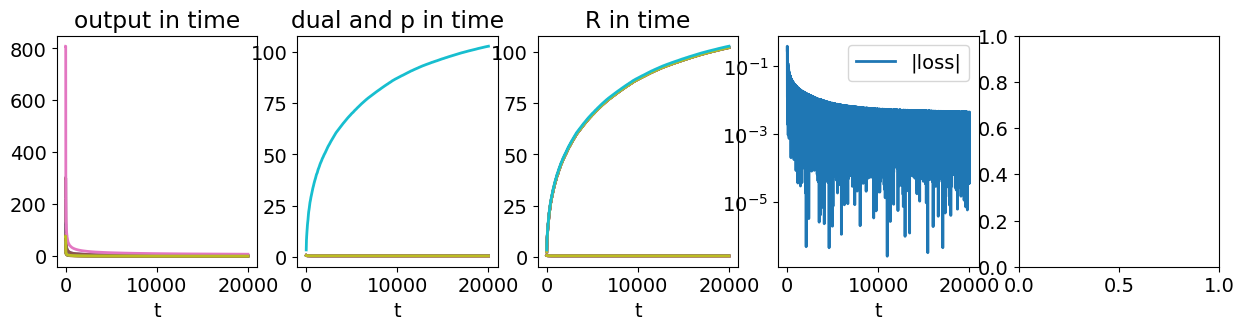

Nin 1
Nout 10
M_norm [0.00398294 0.01011009 0.00778418 0.00636626 0.00165913 0.00165888
 0.00061767 0.0092111  0.00639238 0.00752979]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.384378694829249
no NET assigned in input


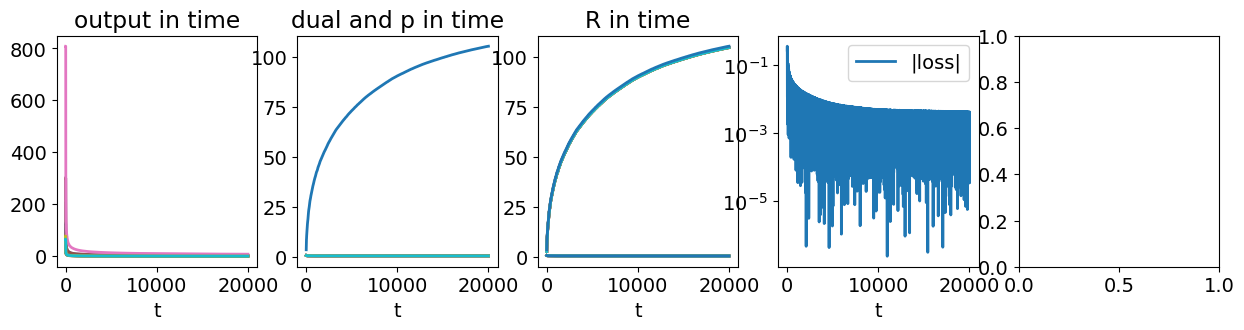

In [22]:
window_for_mean = 1000
n = 10
# random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
random_state_M_vec = array([42]) 
norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])
Nin_vec = [1]
Nout_vec = np.linspace(1,10,10).astype(np.int32)
alpha: float = 0.1  # for network combine attempt

for k, random_state_M in enumerate(random_state_M_vec):
    M_values = random_gen_M(random_state_M, 10)
    M_values_norm = normalize([M_values], norm="l1")[0]/2
    for i, Nin in enumerate(Nin_vec):
        for j, Nout in enumerate(Nout_vec):       
            print('Nin', Nin)
            print('Nout', Nout)
            Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values_norm)
            State = train_loop(Variabs, Strctr, State, BigClass)

            norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
            # norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
            print('norm_mean_loss_ij', norm_mean_loss_ij)

            norm_mean_loss[i, j, k] = norm_mean_loss_ij
            plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

In [ ]:
# print(norm_mean_loss)
# print(np.mean(norm_mean_loss, axis=2))
# np.std(norm_mean_loss, axis=2)